Chandrasekhar mass (computed): 1754926812632832025308697335730067877135268753374314655383552.000 M_sun
White dwarf radius: 1654583660933735516209152.00 km


/var/folders/x2/mg4hfy393fngj494k59zy5z80000gn/T/ipykernel_4898/190805944.py:63: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  m = cumtrapz(dm_dxi, xi, initial=0)


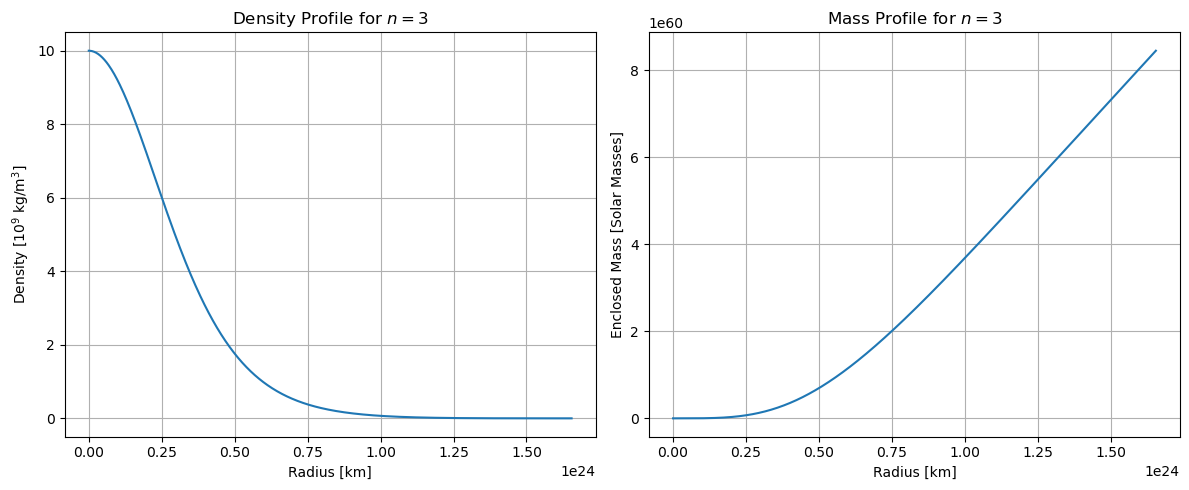

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, cumtrapz

# Constants
G = 6.67430e-11            # Gravitational constant [m^3 kg^-1 s^-2]
h = 6.62607015e-34         # Planck's constant [J·s]
c = 2.99792458e8           # Speed of light [m/s]
m_e = 9.10938356e-31       # Electron mass [kg]
m_u = 1.66053906660e-27    # Atomic mass unit [kg]
M_sun = 1.98847e30         # Solar mass [kg]

# Parameters
mu_e = 2                   # Mean molecular weight per electron
rho_c = 1e10               # Central density [kg/m^3]
n = 3                      # Polytropic index

# Relativistic polytropic constant K
K = (1/8) * (3/np.pi)**(1/3) * (h * c) / ((mu_e * m_u)**(4/3) * m_e**(4/3))

# Lane-Emden equation RHS
def lane_emden_rhs(xi, y, n):
    theta, phi = y
    if xi == 0:
        return [phi, 0]
    return [phi, -2/xi * phi - theta**n]

# Solve the Lane-Emden equation
xi_max = 20
sol = solve_ivp(
    fun=lambda xi, y: lane_emden_rhs(xi, y, n),
    t_span=(1e-10, xi_max),
    y0=[1.0, 0.0],
    dense_output=True,
    max_step=0.01,
    rtol=1e-8,
    atol=1e-10
)

# Extract and truncate solution at first zero of theta
xi = sol.t
theta = sol.y[0]
phi = sol.y[1]
i_zero = np.where(theta <= 0)[0][0]
xi = xi[:i_zero+1]
theta = theta[:i_zero+1]
phi = phi[:i_zero+1]

# Scaling factor and physical radius/mass
xi_1 = xi[-1]
dtheta_dxi = phi[-1]
a = np.sqrt((n + 1) * K / (4 * np.pi * G) * rho_c**((1 - n) / n))
R = a * xi_1               # Radius in meters
M = 4 * np.pi * a**3 * rho_c * (-xi_1**2 * dtheta_dxi)  # Mass in kg

print(f"Chandrasekhar mass (computed): {M / M_sun:.3f} M_sun")
print(f"White dwarf radius: {R / 1e3:.2f} km")

# Mass and density profiles
r = a * xi
rho = rho_c * theta**n
dm_dxi = -4 * np.pi * a**3 * rho_c * xi**2 * phi
m = cumtrapz(dm_dxi, xi, initial=0)
m_solar = m / M_sun
r_km = r / 1e3

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(r_km, rho / 1e9)
plt.xlabel("Radius [km]")
plt.ylabel(r"Density [$10^9$ kg/m$^3$]")
plt.title("Density Profile for $n = 3$")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(r_km, m_solar)
plt.xlabel("Radius [km]")
plt.ylabel("Enclosed Mass [Solar Masses]")
plt.title("Mass Profile for $n = 3$")
plt.grid(True)

plt.tight_layout()
plt.show()
